In [1]:
#%% -------- 1. Critical Configuration Fixes --------
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import splitfolders
from torch.optim.lr_scheduler import OneCycleLR
import torchmetrics

# Hardware config
NUM_CLASSES = 4
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
PRECISION = '16-mixed'
EPOCHS = 100
DATA_ROOT = "2nd Classification"  # Updated path
SPLIT_ROOT = "Split_Dataset"
SEED = 42
CLASS_NAMES = ['Type 0', 'Type 1 Neurapraxia', 'Type 2 Axonotemsis', 'Type 3 Nurotemesis']  # Match folder names exactly

# Verify folder structure
assert os.path.exists(os.path.join(DATA_ROOT, 'Type 0')), "Type 0 folder missing"
assert os.path.exists(os.path.join(DATA_ROOT, 'Type 1 Neurapraxia')), "Type 1 folder missing"

In [2]:
#%% -------- 2. Data Preparation & Sanity Checks --------
# Use existing splits if already created
if not os.path.exists(SPLIT_ROOT):
    import splitfolders
    splitfolders.ratio(
        DATA_ROOT,
        output=SPLIT_ROOT,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

# Simplified transforms for medical images
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets with verification
train_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'val'), val_transform)
test_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'test'), val_transform)

# Final class validation
assert train_dataset.classes == CLASS_NAMES, \
    f"Class mismatch: {train_dataset.classes} vs {CLASS_NAMES}"

# Enhanced class balancing
class_counts = np.bincount(train_dataset.targets)
print("Class distribution:", {name: count for name, count in zip(CLASS_NAMES, class_counts)})
class_weights = torch.tensor(1 / (np.sqrt(class_counts) + 1e-6), dtype=torch.float32)
class_weights = (class_weights / class_weights.sum()) * NUM_CLASSES
sampler = WeightedRandomSampler(class_weights[train_dataset.targets], len(train_dataset), replacement=True)

Class distribution: {'Type 0': 158, 'Type 1 Neurapraxia': 398, 'Type 2 Axonotemsis': 57, 'Type 3 Nurotemesis': 64}


In [7]:
#%% -------- 3. ResMT Model Architecture --------
class MedicalResMT(pl.LightningModule):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=3, dropout=0.1):
        super().__init__()
        # ResNet-50 Backbone
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn_backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        
        # Feature adaptation
        self.feature_adapt = nn.Sequential(
            nn.Conv2d(2048, embed_dim, 1),  # Reduce channels to embed_dim
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Transformer components
        self.positional_encoding = nn.Parameter(torch.randn(1, 49, embed_dim))
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.3),
            nn.Linear(embed_dim, NUM_CLASSES)
        )

        # Freezing strategy
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False
        for param in self.cnn_backbone[-1].parameters():  # Unfreeze last ResNet layer
            param.requires_grad = True

    def forward(self, x):
        # CNN Feature extraction
        x = self.cnn_backbone(x)  # Output: (BS, 2048, 7, 7)
        
        # Feature adaptation
        x = self.feature_adapt(x)  # (BS, embed_dim, 7, 7)
        
        # Prepare for transformer
        x = x.flatten(2).permute(2, 0, 1)  # (49, BS, embed_dim)
        x = x + self.positional_encoding
        
        # Transformer processing
        x = self.transformer_encoder(x)  # (49, BS, embed_dim)
        
        # Aggregate and classify
        x = x.mean(dim=0)  # (BS, embed_dim)
        return self.classifier(x)

In [8]:
#%% -------- 4. Optimized Training Setup --------
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MedicalResNet()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights.to('cuda'))
        
        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # First batch verification
        if batch_idx == 0:
            print("\nFirst batch verification:")
            print("Input shape:", x.shape)
            print("Label distribution:", torch.bincount(y, minlength=NUM_CLASSES))
            print("Sample predictions:", torch.softmax(logits[:3], dim=1).detach().cpu().numpy())
        
        self.log_metrics(logits, y, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.log_metrics(logits, y, 'val')
        return self.criterion(logits, y)

    def log_metrics(self, logits, y, prefix):
        self._update_metrics(getattr(self, f'{prefix}_acc'), 
                            getattr(self, f'{prefix}_f1'), 
                            logits, y)
        self.log_dict({
            f'{prefix}_loss': self.criterion(logits, y),
            f'{prefix}_acc': getattr(self, f'{prefix}_acc'),
            f'{prefix}_f1': getattr(self, f'{prefix}_f1'),
        }, prog_bar=True)

    def _update_metrics(self, acc_metric, f1_metric, logits, y):
        acc_metric(logits, y)
        f1_metric(logits, y)

    def configure_optimizers(self):
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), 
                               lr=2e-4, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch'
            }
        }

In [9]:
#%% -------- 5. Training Execution --------
train_loader = DataLoader(train_dataset, BATCH_SIZE, sampler=sampler, 
                         num_workers=NUM_WORKERS, persistent_workers=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, num_workers=NUM_WORKERS, 
                       persistent_workers=True)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=EPOCHS,
    precision=PRECISION,
    callbacks=[
        pl.callbacks.ModelCheckpoint(monitor='val_f1', mode='max'),
        pl.callbacks.EarlyStopping(monitor='val_f1', patience=10, mode='max')
    ],
    deterministic=True
)

trainer.fit(LitModel(), train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\plugins\precision\amp.py:54: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MedicalResNet      | 23.5 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | train_f1  | MulticlassF1Score  | 0     
5 | val_f1    | MulticlassF1Score  | 0     
-------------------------------------------------
22.1 M    Trainable params
1.4 M     Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([14, 12,  3,  3], device='cuda:0')
Sample predictions: [[0.27930707 0.24831854 0.20121416 0.2711602 ]
 [0.26352534 0.23195073 0.257576   0.24694794]
 [0.2538201  0.24719994 0.23126455 0.26771545]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 9, 14,  5,  4], device='cuda:0')
Sample predictions: [[0.09112449 0.72910404 0.10140883 0.07836267]
 [0.6451512  0.21567693 0.09946997 0.03970189]
 [0.20564398 0.5313366  0.11931217 0.14370729]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([13, 12,  3,  4], device='cuda:0')
Sample predictions: [[7.2647321e-01 1.7162821e-01 4.4969078e-02 5.6929570e-02]
 [9.9256563e-01 4.7983010e-03 1.8753753e-03 7.6068571e-04]
 [6.8940705e-01 1.8503118e-01 6.8360612e-02 5.7201155e-02]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([11,  8,  6,  7], device='cuda:0')
Sample predictions: [[5.9067923e-01 3.9309311e-01 7.5600268e-03 8.6676134e-03]
 [2.6010480e-03 1.4748137e-03 1.4604813e-03 9.9446362e-01]
 [8.4760593e-04 1.5596947e-02 9.8176116e-01 1.7943818e-03]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([10, 12,  5,  5], device='cuda:0')
Sample predictions: [[9.9980992e-01 2.9710254e-05 1.1201589e-04 4.8318791e-05]
 [1.4864924e-02 8.3003289e-01 1.4193258e-01 1.3169593e-02]
 [4.2375751e-02 9.3707913e-01 1.2301977e-02 8.2430411e-03]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 4, 16,  7,  5], device='cuda:0')
Sample predictions: [[9.9894005e-01 5.7450711e-04 2.8495767e-04 2.0049277e-04]
 [4.7440294e-02 9.2490113e-01 5.5104150e-03 2.2148134e-02]
 [9.9994349e-01 5.6049898e-06 4.8412494e-06 4.5977373e-05]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([11,  8,  6,  7], device='cuda:0')
Sample predictions: [[5.0474936e-04 1.4183722e-03 9.9450409e-01 3.5727585e-03]
 [5.6478549e-03 2.7986227e-03 9.9593261e-04 9.9055767e-01]
 [3.7582792e-04 1.5621007e-04 9.9936324e-01 1.0466985e-04]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 8, 11,  8,  5], device='cuda:0')
Sample predictions: [[9.9964142e-01 5.9772312e-05 1.0844528e-04 1.9032738e-04]
 [4.6217130e-03 5.3620815e-02 9.4121510e-01 5.4236688e-04]
 [2.6275162e-04 4.0616363e-04 1.4427903e-03 9.9788839e-01]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 8, 10,  7,  7], device='cuda:0')
Sample predictions: [[5.5943527e-03 1.1087737e-02 9.8021632e-01 3.1015868e-03]
 [6.6566703e-05 9.9988139e-01 8.5962802e-06 4.3400465e-05]
 [9.9785334e-01 9.3136376e-05 1.3686289e-03 6.8483775e-04]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 8, 13,  6,  5], device='cuda:0')
Sample predictions: [[2.8627114e-03 3.7373276e-03 9.9073678e-01 2.6631339e-03]
 [2.3886703e-03 9.9619198e-01 4.2162539e-04 9.9769270e-04]
 [4.8694643e-04 9.8078127e-04 9.9764627e-01 8.8606199e-04]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 7, 13,  6,  6], device='cuda:0')
Sample predictions: [[9.9999619e-01 7.5859282e-07 2.6117957e-06 3.9741488e-07]
 [1.1895780e-03 2.0136838e-03 9.9631882e-01 4.7782494e-04]
 [6.1082633e-06 1.5779506e-06 9.9999130e-01 1.0188014e-06]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 8, 13,  3,  8], device='cuda:0')
Sample predictions: [[9.9935180e-01 2.1102393e-04 3.6819480e-04 6.8912042e-05]
 [8.1685558e-04 9.9835157e-01 6.3430675e-04 1.9726813e-04]
 [1.9726199e-03 3.5165751e-03 4.1072797e-03 9.9040353e-01]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 4, 18,  8,  2], device='cuda:0')
Sample predictions: [[9.9999917e-01 9.2207934e-08 5.3582727e-07 2.6681252e-07]
 [8.9645130e-04 9.9855942e-01 1.2640102e-04 4.1770359e-04]
 [9.9992418e-01 2.1991943e-06 1.2145103e-06 7.2437193e-05]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 7,  9,  4, 12], device='cuda:0')
Sample predictions: [[1.6193871e-03 9.9812227e-01 2.1117636e-04 4.7119818e-05]
 [9.9971145e-01 2.6041912e-04 2.5459703e-05 2.6008727e-06]
 [1.4890754e-03 1.4033799e-01 2.6858549e-03 8.5548705e-01]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([11, 12,  2,  7], device='cuda:0')
Sample predictions: [[1.4926576e-02 1.0984692e-02 4.4036778e-03 9.6968508e-01]
 [1.7123080e-04 9.9937707e-01 2.4913938e-04 2.0254888e-04]
 [1.0449496e-04 2.1863861e-04 3.2816642e-05 9.9964404e-01]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([11,  9,  5,  7], device='cuda:0')
Sample predictions: [[9.0203364e-04 9.9793243e-01 4.5401414e-04 7.1147981e-04]
 [4.9796281e-04 9.9853158e-01 6.8063446e-04 2.8989240e-04]
 [1.7917635e-05 9.9996233e-01 9.7226402e-06 1.0031271e-05]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 7,  8, 10,  7], device='cuda:0')
Sample predictions: [[9.99812424e-01 1.53557165e-04 2.56619805e-05 8.39656695e-06]
 [6.81236503e-04 1.43875832e-05 9.99292731e-01 1.16059955e-05]
 [1.46449602e-03 1.01145904e-03 9.97197270e-01 3.26773210e-04]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([10, 10,  6,  6], device='cuda:0')
Sample predictions: [[5.5049709e-03 5.2069146e-03 8.9428452e-04 9.8839378e-01]
 [9.9973041e-01 9.7598873e-05 9.0088077e-05 8.1866077e-05]
 [8.1282837e-04 9.9829215e-01 2.9209600e-04 6.0286414e-04]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 4, 13, 10,  5], device='cuda:0')
Sample predictions: [[1.0743273e-03 5.4657343e-04 9.9792588e-01 4.5312534e-04]
 [1.8105140e-02 2.0910237e-02 9.5622456e-01 4.7600511e-03]
 [2.0258408e-02 9.6803588e-01 3.7529222e-03 7.9526985e-03]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([7, 9, 7, 9], device='cuda:0')
Sample predictions: [[2.3146208e-04 4.8224488e-03 9.9415696e-01 7.8916753e-04]
 [1.8850469e-04 9.9978429e-01 1.5809443e-05 1.1387114e-05]
 [9.9965107e-01 2.3942674e-04 7.0843555e-05 3.8743325e-05]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 7, 11,  8,  6], device='cuda:0')
Sample predictions: [[9.0804633e-06 9.9998963e-01 2.8070886e-07 9.4223572e-07]
 [2.2962027e-05 3.6260310e-06 1.6343804e-06 9.9997187e-01]
 [9.9997604e-01 1.4009075e-05 6.7347682e-06 3.3274471e-06]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([10, 11,  5,  6], device='cuda:0')
Sample predictions: [[5.7212549e-04 4.9224071e-04 2.4320133e-04 9.9869245e-01]
 [3.9945744e-04 9.9881613e-01 1.8942884e-04 5.9499004e-04]
 [9.9935263e-01 3.6072111e-04 1.3785344e-04 1.4876427e-04]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 7,  8,  6, 11], device='cuda:0')
Sample predictions: [[4.8612707e-04 1.5209569e-03 7.8280464e-05 9.9791473e-01]
 [5.4031628e-04 9.9910539e-01 1.9780305e-04 1.5647509e-04]
 [9.9996257e-01 2.0744268e-05 9.1157563e-06 7.6463093e-06]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([ 7, 16,  4,  5], device='cuda:0')
Sample predictions: [[1.2389715e-03 9.9793470e-01 3.7934390e-04 4.4697634e-04]
 [9.9983978e-01 1.5471958e-06 1.3160480e-04 2.7105196e-05]
 [5.8480469e-03 9.8926991e-01 2.7222517e-03 2.1597964e-03]]


Validation: |          | 0/? [00:00<?, ?it/s]


First batch verification:
Input shape: torch.Size([32, 3, 224, 224])
Label distribution: tensor([11, 14,  3,  4], device='cuda:0')
Sample predictions: [[4.5751702e-05 1.4312305e-05 3.3933440e-05 9.9990594e-01]
 [1.2470775e-02 9.8416752e-01 2.5218662e-03 8.3978439e-04]
 [5.8630256e-05 9.9988091e-01 2.0460915e-05 3.9904346e-05]]


Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\fabric\utilities\cloud_io.py:55: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Classification Report:
                    precision    recall  f1-score   support

            Type 0       1.00      1.00      1.00        35
Type 1 Neurapraxia       1.00      1.00      1.00        86
Type 2 Axonotemsis       1.00      1.00      1.00        13
Type 3 Nurotemesis       1.00      1.00      1.00        15

          accuracy                           1.00       149
         macro avg       1.00      1.00      1.00       149
      weighted avg       1.00      1.00      1.00       149



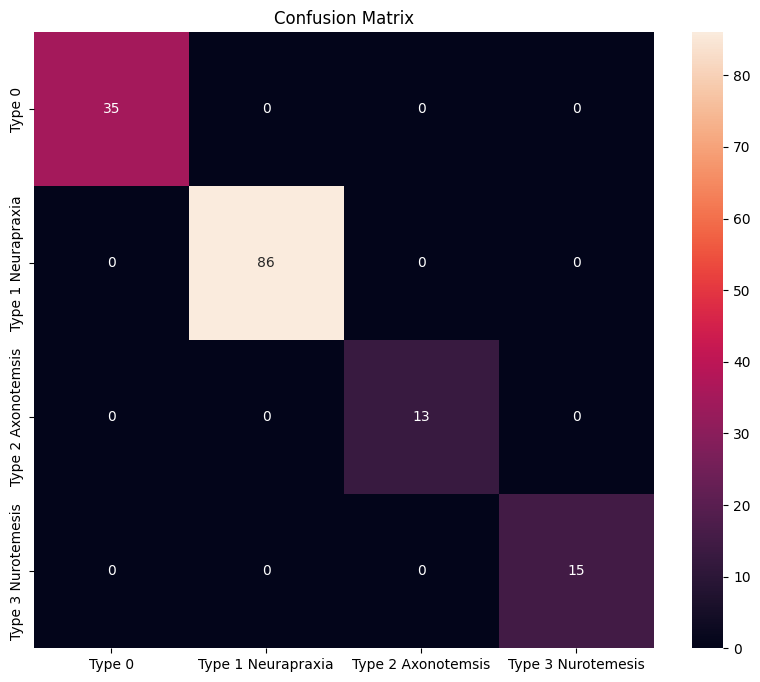

In [10]:
#%% -------- 6. Final Evaluation --------
best_model = LitModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
test_loader = DataLoader(test_dataset, BATCH_SIZE, num_workers=NUM_WORKERS)

def evaluate():
    best_model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(best_model.device), y.to(best_model.device)
            logits = best_model(x)
            all_preds.extend(torch.argmax(logits, 1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=CLASS_NAMES))
    
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(all_targets, all_preds), 
                annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.show()

evaluate()